In [1]:
# Base Libraries
import pandas as pd
import numpy as np
import math
from scipy import stats

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use('fivethirtyeight')

# Import yahoo finance libraries
import yfinance as yf

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score

# Classifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

def f(x):
    return 1/(np.sqrt(2*np.pi))*math.exp(-0.5*x**2)

In [113]:
df = yf.download('VT', start='1999-12-31', end='2022-10-01', progress=False)
df.to_excel('output.xlsx',index=0)
#df['Forward Returns'] = np.log(df['Adj Close']).diff().shift(-1)
df['returns'] = df['Adj Close'].diff()/df['Adj Close'].shift(1)
df = df.dropna()

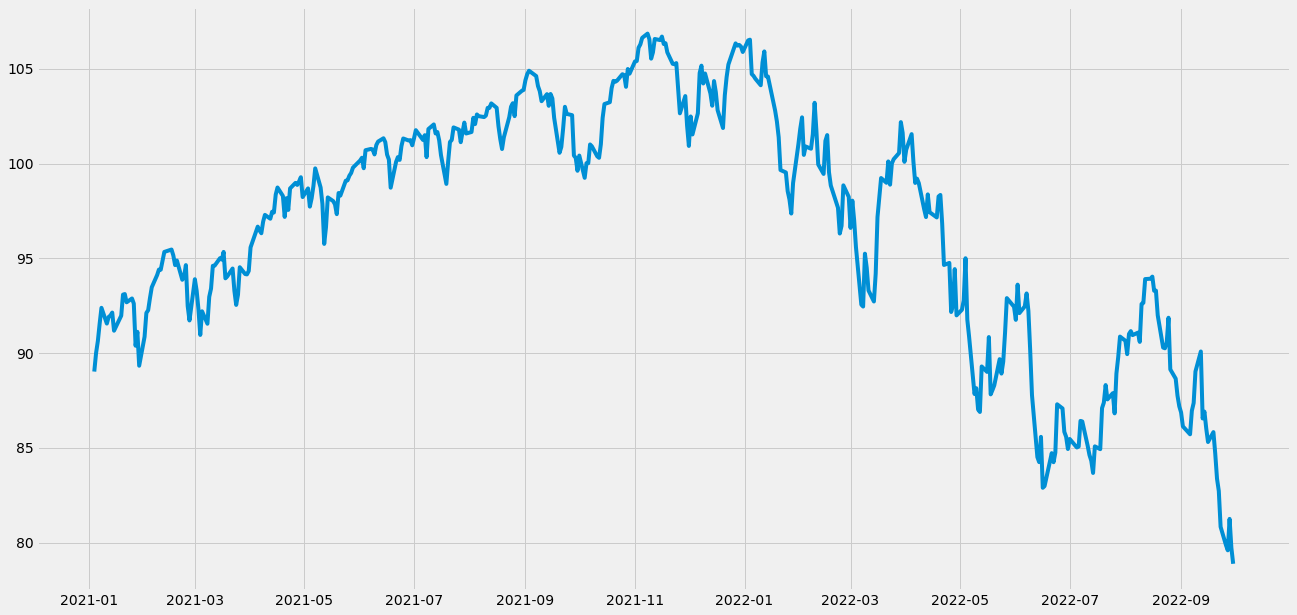

In [114]:
#gráfico do equity
plt.figure(figsize=(20,10))

plt.plot(df.loc['2021-01-01':'2022-10-01','Adj Close'])

In [117]:
#suponha um investimento de USD 100 no periodo do grafico acima
k=[100]
for i in df.loc['2021-01-01':'2022-10-01','returns']:
    k.append(100*(1+i))
ivst = pd.DataFrame(k[:-1],index = df.loc['2021-01-01':'2022-10-01','Adj Close'].index,columns=['value'])
ivst['returns'] = ivst.diff()/ivst.shift(1)

ivst = ivst.dropna()

In [120]:
df.loc['2021-01-01':'2022-10-01','returns']

Date
2021-01-04   -0.005725
2021-01-05    0.010972
2021-01-06    0.007092
2021-01-07    0.010136
2021-01-08    0.009084
                ...   
2022-09-26   -0.012001
2022-09-27   -0.003381
2022-09-28    0.020857
2022-09-29   -0.018831
2022-09-30   -0.010537
Name: returns, Length: 440, dtype: float64

In [119]:
ivst['returns'].head()

Date
2021-01-05   -0.005725
2021-01-06    0.016793
2021-01-07   -0.003838
2021-01-08    0.003023
2021-01-11   -0.001042
Name: returns, dtype: float64

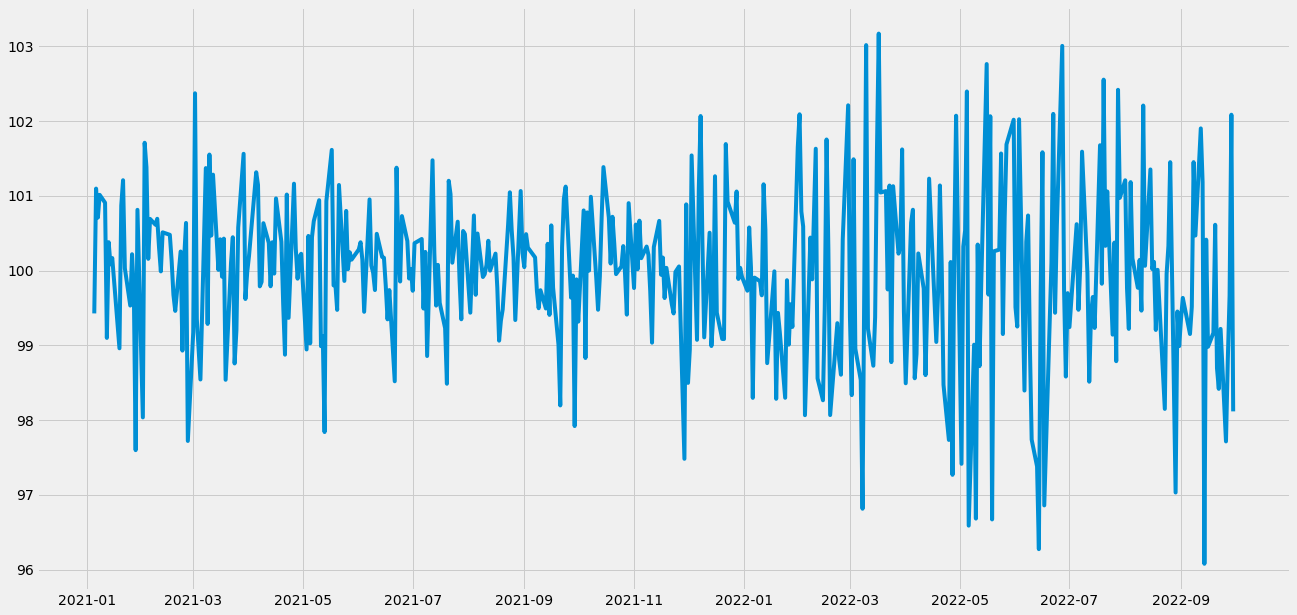

In [111]:
plt.figure(figsize=(20,10))

plt.plot(ivst['value'])

In [82]:
ivst.head()

,value,Return
Date,,
2021-01-04,100.000000,0.010912
2021-01-05,101.091247,-0.003804
2021-01-06,100.706722,0.002997
2021-01-07,101.008555,-0.001032
2021-01-08,100.904324,-0.017924


In [83]:
ivst.tail()

,value,Return
Date,,
2022-09-22,99.217286,-0.015407
2022-09-23,97.688678,0.011301
2022-09-26,98.792690,0.008793
2022-09-27,99.661330,0.024111
2022-09-28,102.064241,-0.038851


In [78]:
ivst.shift(0)

,value
Date,
2021-01-04,100.000000
2021-01-05,101.091247
2021-01-06,100.706722
2021-01-07,101.008555
2021-01-08,100.904324
...,...
2022-09-23,97.688678
2022-09-26,98.792690
2022-09-27,99.661330


In [77]:
ivst.shift(-1)

,value
Date,
2021-01-04,101.091247
2021-01-05,100.706722
2021-01-06,101.008555
2021-01-07,100.904324
2021-01-08,99.095676
...,...
2022-09-23,98.792690
2022-09-26,99.661330
2022-09-27,102.064241


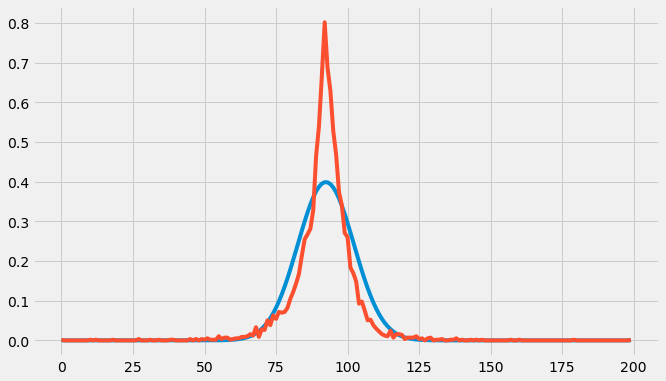

In [5]:
v = pd.DataFrame(df.iloc[:,4:])
v = v.drop(['Volume'],axis=1)
v['scaled return'] = (v['Forward Returns'] - np.mean(v['Forward Returns']))/np.std(v['Forward Returns'])
v = v.dropna()

u = pd.DataFrame(columns=['Freq','PDF','Normal'])

res = stats.relfreq(v['scaled return'],numbins=200)
u['Freq'] = res.frequency*len(v)

u['PDF'] = u['Freq']/len(v)/res.binsize
k=[res.lowerlimit]
for i in range(len(u)-1):
    k.append(k[i] + res.binsize)
u['bucket'] = k

u['Normal'] = np.array([f(i) for i in u['bucket']])
plt.figure(figsize=(10,6))
plt.plot(u['Normal'])
plt.plot(u['PDF'])

In [6]:
#based on the underlying distribution of the data we will decide the feature transformation
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Forward Returns
count,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000,5.616000e+03,5616.000000
mean,181.076249,182.136055,179.902946,181.076607,154.353552,1.098936e+08,0.000259
std,90.519359,90.898279,90.071269,90.523022,97.826428,9.513851e+07,0.012393
min,67.949997,70.000000,67.099998,68.110001,52.195717,1.436600e+06,-0.115886
25%,117.970001,118.777498,117.059998,117.867502,85.637615,4.955988e+07,-0.004662
50%,141.799995,142.424995,140.764999,141.595001,106.892784,8.144725e+07,0.000681
75%,216.559998,217.132496,215.750000,216.602497,194.288651,1.444076e+08,0.005923
max,479.220001,479.980011,476.059998,477.709991,472.242310,8.710263e+08,0.135577


In [7]:
#feature engineering, where we create features out of the original dataset
#Here we create the intraday range, and the Open close range.
#And we will use that to predict If the tomorrow’s return is greater than the median of the forward return
# Predictors
df['O-C'] = df.Open - df.Close
df['H-L'] = df.High - df.Low
X = df[['O-C', 'H-L']].values

#Here, the target variable is to identify whether SPY will close up or down on the next trading day.If the tomorrow’s
#return is greater than the median of the forward return, we will buy the SPY, else we will sell SPY.
# Target

#y = np.where(df['Forward Returns']>=np.quantile(df['Forward Returns'], q=0.5), 1,-1)

#Different approach for the label, classifying returns that are close to zero
y = np.where(df['Adj Close'] > 0.995 * df['Adj Close'].shift(-1),1,-1)

# Value counts for class 1 and -1

#now we note class inbalance. Class weights is the most prefered choice for time series class imbalances. Avois Stratified sampling 
pd.Series(y).value_counts()

array([[-0.03125 ,  1.25    ],
       [ 2.8125  ,  4.375   ],
       [ 3.78125 ,  4.421875],
       [-0.0625  ,  4.28125 ],
       [ 1.875   ,  3.75    ]])

In [10]:
#for time series we always keep shiffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale and fit the model
pipe = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", KNeighborsClassifier())
]) 
pipe.fit(X_train, y_train)

# Predicting the test dataset
y_pred = pipe.predict(X_test)

acc_train = accuracy_score(y_train, pipe.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

# predict_proba
probs = pipe.predict_proba(X_test)
probs[:10]

Train and Test Size 4492, 1124


In [19]:
#In the exam ou will be evaluated whether the 7 step for model building and not accuracy of your model
#as accuracy is very difficult

#In The exam/Project you are expected to identify one particular trend. Wheter you decide to devise your feature
#engeneering or labeling to catch the downside, and you want to devise your strategy based on that

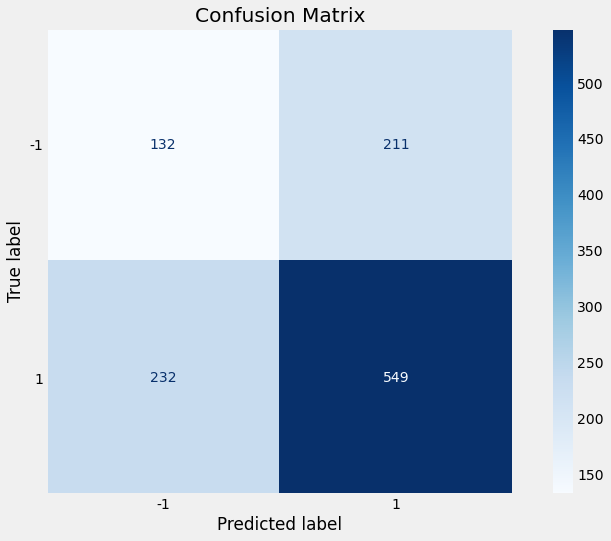

In [20]:
# Plot confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

In [22]:
df['O-C'] = df.Open - df.Close
df['H-L'] = df.High - df.Low
X = df[['O-C', 'H-L']].values
y = np.where(df['Forward Returns']>=np.quantile(df['Forward Returns'], q=0.5), 1,-1)
#for time series we always keep shiffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Scale and fit the model
pipe = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", KNeighborsClassifier())
]) 
pipe.fit(X_train, y_train)

# Predicting the test dataset
y_pred = pipe.predict(X_test)

acc_train = accuracy_score(y_train, pipe.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.6879, Test Accuracy: 0.4982


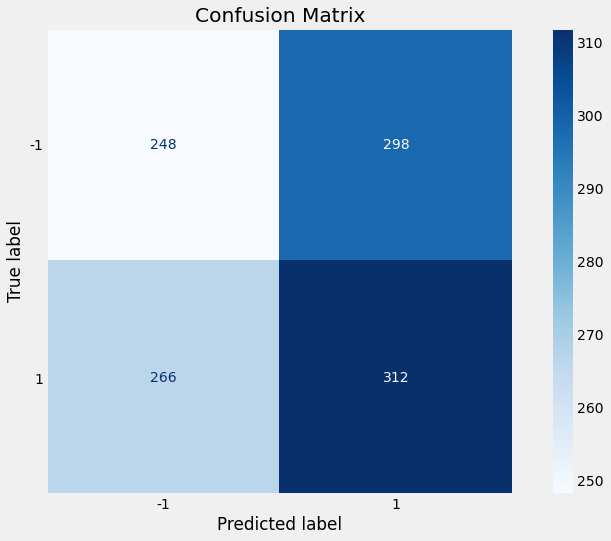

In [23]:
# Plot confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)